<a href="https://colab.research.google.com/github/anky19698/Cricket_Analytics/blob/main/Testing_Model_R101_FPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
import numpy as np

# Importing Collected Keypoints for Cricket Shot Dataset from R50-FPN

keypoints = []
labels = []
file_path = 'img_data_R101.csv'
data = np.genfromtxt(file_path, delimiter=',')
# print(data)

for p in data:
    keypoints.append(np.array(p))

labels_path = 'img_data_R101_labels.csv'

label_data = open(labels_path)

for label in label_data.readlines():
    labels.append(label.split('\n')[0])


print(len(keypoints), len(labels))

1240 1240


In [108]:
import numpy as np
import pandas as pd
# for normalization
from sklearn.preprocessing import StandardScaler
# define normalizer
scaler= StandardScaler()
# normalize keypoints
keypoints = scaler.fit_transform(keypoints)
# convert to an array
keypoints = np.array(keypoints)

In [109]:
# converting the target categories into numbers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(labels)

# for creating training and validation sets
from sklearn.model_selection import train_test_split
# split keypoints and labels in 80:20
x_tr, x_val, y_tr, y_val = train_test_split(keypoints, y, test_size=0.2, stratify=labels,
                                        random_state=120)

# converting the keypoints and target value to tensor
import torch
x_tr = torch.Tensor(x_tr)
x_val = torch.Tensor(x_val)
y_tr = torch.Tensor(y_tr)
y_tr = y_tr.type(torch.long)
y_val = torch.Tensor(y_val)
y_val = y_val.type(torch.long)

# shape of training and validation set
(x_tr.shape, y_tr.shape), (x_val.shape, y_val.shape)

((torch.Size([992, 34]), torch.Size([992])),
 (torch.Size([248, 34]), torch.Size([248])))

In [110]:
# importing libraries for defining the architecture of model
from torch.autograd import Variable
from torch.optim import Adam
from torch.nn import Linear, ReLU, Sequential, Softmax, CrossEntropyLoss, Dropout
# defining the model architecture
model = Sequential(Linear(34, 64),
                   ReLU(),
                   Linear(64, 4),
                   Softmax()
                   )

# Define the model architecture with additional layers
# model = Sequential(
#     Linear(34, 128),  # Input layer to a hidden layer with 128 neurons
#     ReLU(),           # Activation function
#     Dropout(0.5),     # Dropout layer for regularization (optional)
#     Linear(128, 64),  # Another hidden layer with 64 neurons
#     ReLU(),           # Activation function
#     Dropout(0.5),     # Dropout layer for regularization (optional)
#     Linear(64, 32),   # Another hidden layer with 32 neurons
#     ReLU(),           # Activation function
#     Dropout(0.5),     # Dropout layer for regularization (optional)
#     Linear(32, 4),    # Output layer with 4 neurons (assuming 4 classes)
#     Softmax()         # Softmax activation for multiclass classification
# )



# define optimizer and loss function
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(x_tr), Variable(y_tr)
    # getting the validation set
    x_valid, y_valid = Variable(x_val), Variable(y_val)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_valid = x_valid.cuda()
        y_valid = y_valid.cuda()
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(x_train)
    output_val = model(x_valid)
    # computing the training and validation loss
    loss_train = criterion(output_train, y_train)
    loss_val = criterion(output_val, y_valid)
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    if epoch%500 == 0:
        # printing the validation loss
        print('Epoch : ',epoch+1, 't', 'loss :', loss_val.item())
    return loss_val.item()

In [111]:
# defining the number of epochs
n_epochs = 5000

# training the model
for epoch in range(n_epochs):
    train(epoch)

# patience = 100
# best_loss = float('inf')
# counter = 0  # Counter to track how many epochs have passed without improvement

# # Training loop with early stopping
# for epoch in range(n_epochs):
#     val_loss = train(epoch)

#     # Check if validation loss has improved
#     if val_loss < best_loss:
#         best_loss = val_loss
#         counter = 0  # Reset the counter if there's improvement
#     else:
#         counter += 1  # Increment the counter if there's no improvement

#     # Check if we should stop training due to lack of improvement
#     if counter >= patience:
#         print(f'Early stopping at epoch {epoch}.')
#         break

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch :  1 t loss : 1.3927544355392456
Epoch :  501 t loss : 0.9319081902503967
Epoch :  1001 t loss : 0.9243386387825012
Epoch :  1501 t loss : 0.9263994097709656
Epoch :  2001 t loss : 0.9272490739822388
Epoch :  2501 t loss : 0.9249563813209534
Epoch :  3001 t loss : 0.9237751960754395
Epoch :  3501 t loss : 0.9237299561500549
Epoch :  4001 t loss : 0.9233332872390747
Epoch :  4501 t loss : 0.9356868863105774


In [115]:
# to check the model performanc
from sklearn.metrics import accuracy_score
# get validation accuracy
x, y = Variable(x_val), Variable(y_val)

class_names = ['cutshot', 'drive', 'pullshot', 'sweep']

if torch.cuda.is_available():
  x_val = x.cuda()
  y_val = y.cuda()
pred = model(x_val)
final_pred = np.argmax(pred.cpu().data.numpy(), axis=1)

print("Model Test Accuracy:", round(accuracy_score(y_val.cpu(), final_pred)*100, 2))


Model Test Accuracy: 81.85


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


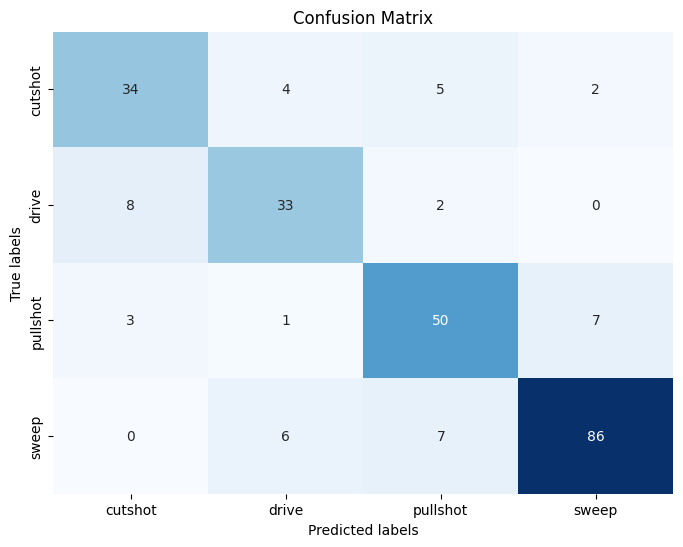

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_val.cpu(), final_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Testing Model on New Images

In [46]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Setting Up Detectron2 for Keypoints

In [ ]:
pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [117]:
from detectron2 import model_zoo

from detectron2.engine import DefaultPredictor

from detectron2.config import get_cfg

cfg = get_cfg()

cfg.MODEL.DEVICE = 'cpu'

cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")

# cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64

cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.MAX_ITER = 2000

predictor = DefaultPredictor(cfg)

In [118]:
# define function that extracts the keypoints for an image
keypoints   = []
lbl = []
def extract_keypoints(img):
  # make predictions
  outputs = predictor(img)
  # fetch keypoints
  kps = outputs['instances'].pred_keypoints
  # convert to numpy array
  kp = kps.cpu().numpy()
  # print(kp)
  # if keypoints detected
  if(len(kps)>0):
    # fetch keypoints of a person with maximum confidence score
    kp = kp[0]
    kp = np.delete(kp,2,1)
    # convert 2D array to 1D array
    kp = kp.flatten()
    # return keypoints
    return kp
    # keypoints.append(kp)

    # print(len(keypoints))

### Importing Test Images and Extracting Keypoints

In [119]:
import os
import cv2

new_images = []
target_width, target_height = 250, 250
path = '/content/drive/MyDrive/test_images/'
keypoints = []

i = 0
names = os.listdir(path)
for name in names:
    image = cv2.imread(path + name)
    # Resize image while maintaining aspect ratio
    height, width, _ = image.shape
    aspect_ratio = width / height
    if aspect_ratio > 1:  # landscape orientation
        new_width = target_width
        new_height = int(new_width / aspect_ratio)
    else:  # portrait or square orientation
        new_height = target_height
        new_width = int(new_height * aspect_ratio)

    # Resize image to target dimensions
    resized_image = cv2.resize(image, (new_width, new_height))

    # Create padding to achieve target dimensions
    top_pad = (target_height - new_height) // 2
    bottom_pad = target_height - new_height - top_pad
    left_pad = (target_width - new_width) // 2
    right_pad = target_width - new_width - left_pad
    padded_image = cv2.copyMakeBorder(resized_image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    kp = extract_keypoints(padded_image)
    new_images.append(padded_image)
    i+=1
    print(i)
    keypoints.append(kp)

# print(keypoints)

1
2
3
4
5
6
7
8
9
10
11


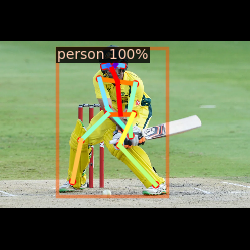

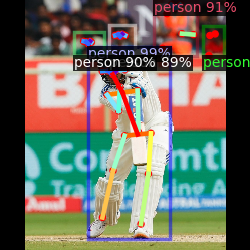

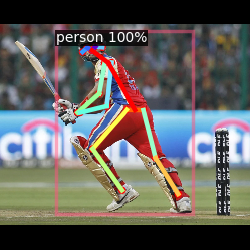

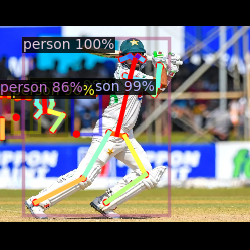

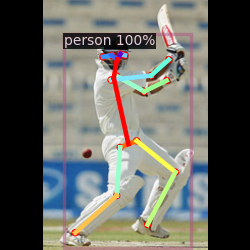

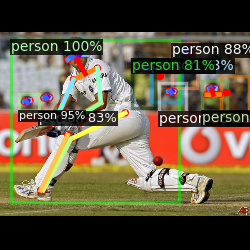

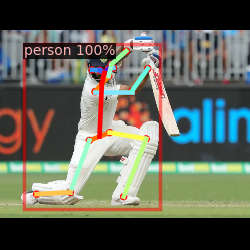

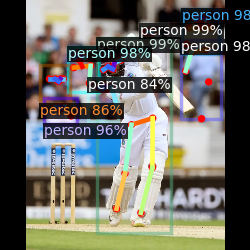

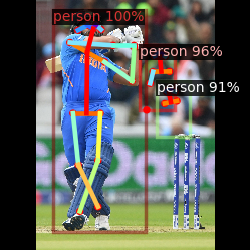

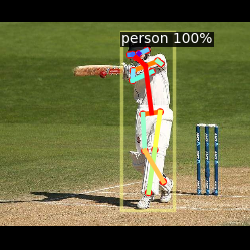

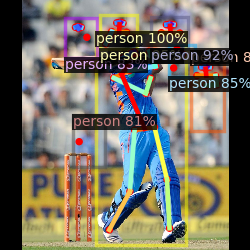

In [120]:
import random

# for drawing predictions on images
from detectron2.utils.visualizer import Visualizer
# to obtain metadata
from detectron2.data import MetadataCatalog
# to display an image
# from google.colab.patches import cv2_imshow
# randomly select images
for img in new_images:
    # make predictions
    outputs = predictor(img)
    # use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    # draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # display image
    cv2_imshow(v.get_image()[:, :, ::-1])

In [121]:
t_kp = torch.Tensor(keypoints)

print(t_kp.shape)

torch.Size([11, 34])


In [122]:
predictions = model(t_kp)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


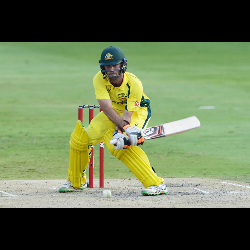

sweep


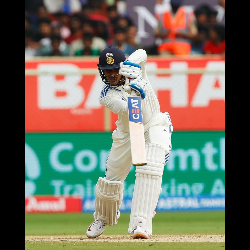

drive


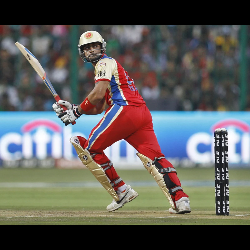

sweep


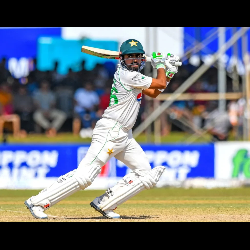

cutshot


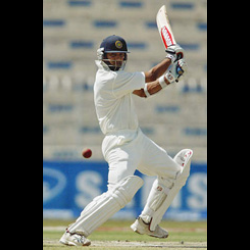

drive


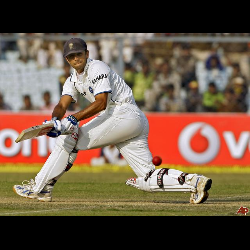

sweep


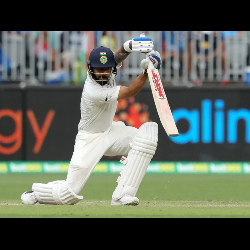

drive


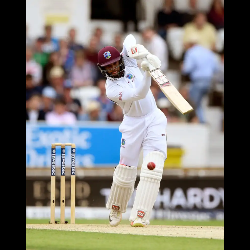

drive


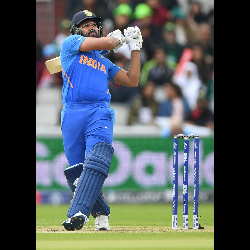

drive


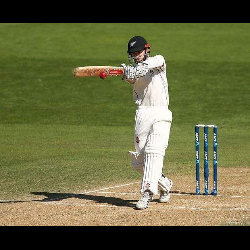

sweep


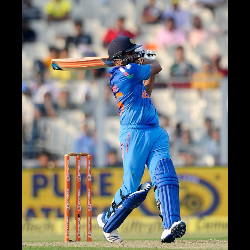

drive
['sweep', 'drive', 'sweep', 'cutshot', 'drive', 'sweep', 'drive', 'drive', 'drive', 'sweep', 'drive']


In [123]:
from google.colab.patches import cv2_imshow

class_names = ['cutshot', 'drive', 'pullshot', 'sweep']

# List to store predicted class names
predicted_class_names = []

# Iterate over the predictions
for i in range(len(predictions)):
    prediction = predictions[i]
    # Convert the tensor to a numpy array
    prediction_np = prediction.detach().cpu().numpy()  # Convert to numpy array
    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(prediction_np)
    # Get the class name corresponding to the index
    predicted_class_name = class_names[predicted_class_index]
    # Append the predicted class name to the list
    predicted_class_names.append(predicted_class_name)
    cv2_imshow(new_images[i])
    print(predicted_class_name)
# Print or use the predicted class names as needed
print(predicted_class_names)